## Define Function and its Symmetry

In [1]:
import random
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
RANDOM_SEED = 41

from constants import DTYPE, LABEL_FONT_SIZE

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

N_RUNS = 10
_random_seeds = [random.randint(0, 10000) for _ in range(N_RUNS)]

## Generate Dataset

In [2]:
N_SAMPLES = 100_000
n_features = 2
LAMBDA = 1
RHO = 1

SYMMETRY_DIM = 1

cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=DTYPE)

def f(state, cost_matrix=cost_matrix):
    """Evaluates f:M \rightarrow N for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

p = torch.randn(N_SAMPLES, n_features, dtype=DTYPE)
n = f(p)

## Symmetry Discovery

### Step 1: Learn Basis of Kernel at each Point

In [3]:
KERNEL_DIM=1
EPSILON_BALL = 0.05
EPSILON_LEVEL_SET = 0.005

from src.learning.symmetry_discovery.differential.kernel_pprox import pointwise_kernel_approx

kernel_bases = pointwise_kernel_approx(p=p, n=n, kernel_dim=KERNEL_DIM, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_pprox.py:62: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
Compute Kernel Samples...: 100000it [00:02, 44190.16it/s]
Compute Point-Wise Bases...: 100%|██████████| 100000/100000 [00:06<00:00, 16465.81it/s]
INFO:root:Computed kernel bases from:
  - multiple tangent vectors for 66.66% of samples (good)
  - one tangent vector for 13.72% of samples (okay)
  - no tangent vector for 19.62% of samples (not good, no basis).


## Compare Both Approaches

In [4]:
diff_func_generators = []
N_STEPS = 30_000
BATCH_SIZE=128

In [5]:
from src.experiments.diff_vs_func.compare_generators import DiffFuncGenerator
g_oracle = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE).unsqueeze(0)

for idx_run in range(N_RUNS):
    print(f"Run {idx_run+1} out of {N_RUNS}")

    g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)
    g_0 = torch.nn.Parameter(g_init_all)

    diff_func_generator = DiffFuncGenerator(
        g_0=g_0,
        p=p,
        bases=kernel_bases,
        func=f,
        batch_size=BATCH_SIZE,
        n_steps = N_STEPS,
        g_oracle=g_oracle,
        random_seed=_random_seeds[idx_run]
    )
    diff_func_generator.optimize()
    diff_func_generators.append(diff_func_generator)

Run 1 out of 10


/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:53: UserWarning: Differential Generator is not Normalized During Training
  warnings.warn("Differential Generator is not Normalized During Training")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/functional/func_generator.py:50: UserWarning: Sampled group actions are in 2pi range.
  warnings.warn("Sampled group actions are in 2pi range.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/experiments/diff_vs_func/compare_generators.py:35: UserWarning: Current evaluation only supports rotation symmetry.
  warnings.warn("Current evaluation only supports rotation symmetry.")
Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [03:23<00:00, 147.17it/s, Generator Span Diff. Loss=0.88, Generator Span Func. Loss=0.53]   


Run 2 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [03:18<00:00, 151.07it/s, Generator Span Diff. Loss=1.56, Generator Span Func. Loss=0.03]  


Run 3 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [03:10<00:00, 157.17it/s, Generator Span Diff. Loss=0.94, Generator Span Func. Loss=0.05]   


Run 4 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [03:17<00:00, 151.72it/s, Generator Span Diff. Loss=0.64, Generator Span Func. Loss=138.56] 


Run 5 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [02:56<00:00, 169.80it/s, Generator Span Diff. Loss=0.84, Generator Span Func. Loss=0.02]  


Run 6 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [02:46<00:00, 180.33it/s, Generator Span Diff. Loss=2.12, Generator Span Func. Loss=0.02]   


Run 7 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [02:41<00:00, 185.69it/s, Generator Span Diff. Loss=3.29, Generator Span Func. Loss=0.03]  


Run 8 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [02:39<00:00, 187.54it/s, Generator Span Diff. Loss=1.63, Generator Span Func. Loss=0.54]   


Run 9 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [02:52<00:00, 174.18it/s, Generator Span Diff. Loss=0.51, Generator Span Func. Loss=0.03]   


Run 10 out of 10


Learning Differential and Functional Generator: 100%|██████████| 30000/30000 [03:11<00:00, 156.94it/s, Generator Span Diff. Loss=1.99, Generator Span Func. Loss=0.03]   


## Visualize Learned Generators
- Top row: differential
- Bottom row: functional

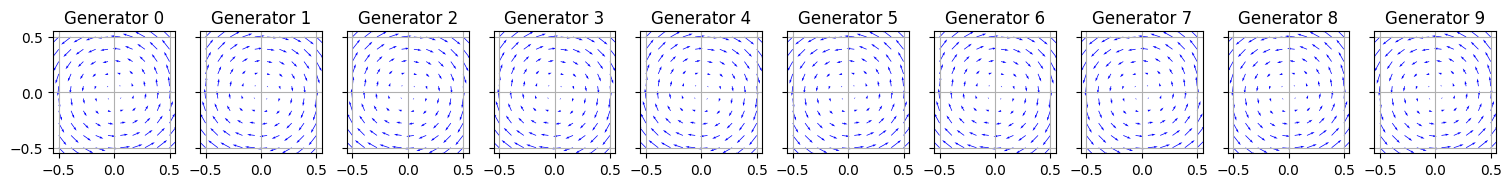

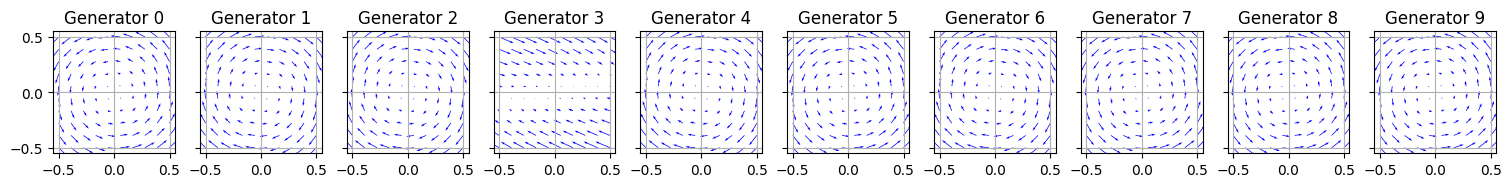

In [8]:
from src.plotting.differential.vector_field import plot_learned_generator

fig, axes = plt.subplots(1, N_RUNS, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    plot_learned_generator(diff_func_generators[i].g_diff_norm, ax, title=f"Generator {i}", quiver_scale=4)
fig, axes = plt.subplots(1, N_RUNS, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    plot_learned_generator(diff_func_generators[i].g_func_norm, ax, title=f"Generator {i}", quiver_scale=4)